### Try to visualize with DataShader

In [88]:
import pandas as pd
import numpy as np

import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from datashader import transfer_functions as tf
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display

from bokeh.plotting import figure, output_notebook, show
output_notebook()

Loading BokehJS ...

### Ingest data

In [89]:
def load_hurricane_data(_path="../data/allstorms.csv"):
    data = pd.read_csv(_path)

    # data dictionary
    # N/A,Year,#,BB,BB,N/A,YYYY-MM-DD HH:MM:SS,N/A,deg_north,deg_east,kt,mb,N/A,%,%,N/A

    data.loc[:,"Season"] = data.loc[:,"Season"].apply(lambda x: int(x))

    print data.loc[:,"Basin"].unique()
    # array(['BB', ' SI', ' NA', ' EP', ' SP', ' WP', ' NI', ' SA'], dtype=object)

    data.loc[:, "Basin"] = data.loc[:, "Basin"].apply(lambda x: x.replace(" ", ""))

    print data.loc[:,"Basin"].unique()
    # ['BB' 'SI' 'NA' 'EP' 'SP' 'WP' 'NI' 'SA']

    data_na = data[data.loc[:, "Basin"] == "NA"]

    len(data_na)
    
    return data_na

data_na = load_hurricane_data()

[' SI' ' NA' ' EP' ' SP' ' WP' ' NI' ' SA']
['SI' 'NA' 'EP' 'SP' 'WP' 'NI' 'SA']


In [90]:
data_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49035 entries, 35 to 196401
Data columns (total 16 columns):
Serial_Num              49035 non-null object
Season                  49035 non-null int64
Num                     49035 non-null int64
Basin                   49035 non-null object
Sub_basin               49035 non-null object
Name                    49035 non-null object
ISO_time                49035 non-null object
Nature                  49035 non-null object
Latitude                49035 non-null float64
Longitude               49035 non-null float64
Wind(WMO)               49035 non-null float64
Pres(WMO)               49035 non-null float64
Center                  49035 non-null object
Wind(WMO) Percentile    49035 non-null float64
Pres(WMO) Percentile    49035 non-null float64
Track_type              49035 non-null object
dtypes: float64(6), int64(2), object(8)
memory usage: 6.4+ MB


In [91]:
def safsimpsonize(wind):
    '''
    Takes in wind speed
    
    Returns saffir-simpson hurricane category with 0 and -1 for tropical storm/depression
    which doesn't make perfect sense as scales go but this maintains categories but allows
    the model/visualization to detect when something is a tropical depression
    
    According to: https://en.wikipedia.org/wiki/Saffir%E2%80%93Simpson_scale
    
    Return:  Category:   Wind Speed Range: (mph, seriously?)
    5        Cat 5      157 <= v
    4        Cat 4      130 <= v < 157
    3        Cat 3      111 <= v < 130
    2        Cat 2      96 <= v < 111
    1        Cat 1      74 <= v < 96
    0        Storm      39 <= v < 74
    -1       Depression v < 39
    '''
    if wind >= 157:
        return 5
    elif wind >= 130:
        return 4
    elif wind >= 111:
        return 3
    elif wind >= 96:
        return 2
    elif wind >= 74:
        return 1
    elif wind >= 39:
        return 0
    else:
        return -1
    
data_na.loc[:,"saffir_simpson_cat"] = data_na["Wind(WMO)"].apply(lambda x: safsimpsonize(x))

In [63]:
NA_BASIN = x_range, y_range = ((-110.0, -20.0), (0, 50.0))

background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))

plot_width  = int(750)
plot_height = int(plot_width//1.2)

def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

def create_image(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(data_na, 'Longitude', 'Latitude',  ds.count('saffir_simpson_cat'))
    img = tf.shade(agg, cmap=Hot, how='eq_hist')
    return tf.dynspread(img, threshold=0.5, max_px=4)

p = base_plot(background_fill_color=background)
export(create_image(*NA_BASIN),"North_American_Hurricanes")
InteractiveImage(p, create_image)

In [11]:
from mpl_toolkits.basemap import Basemap

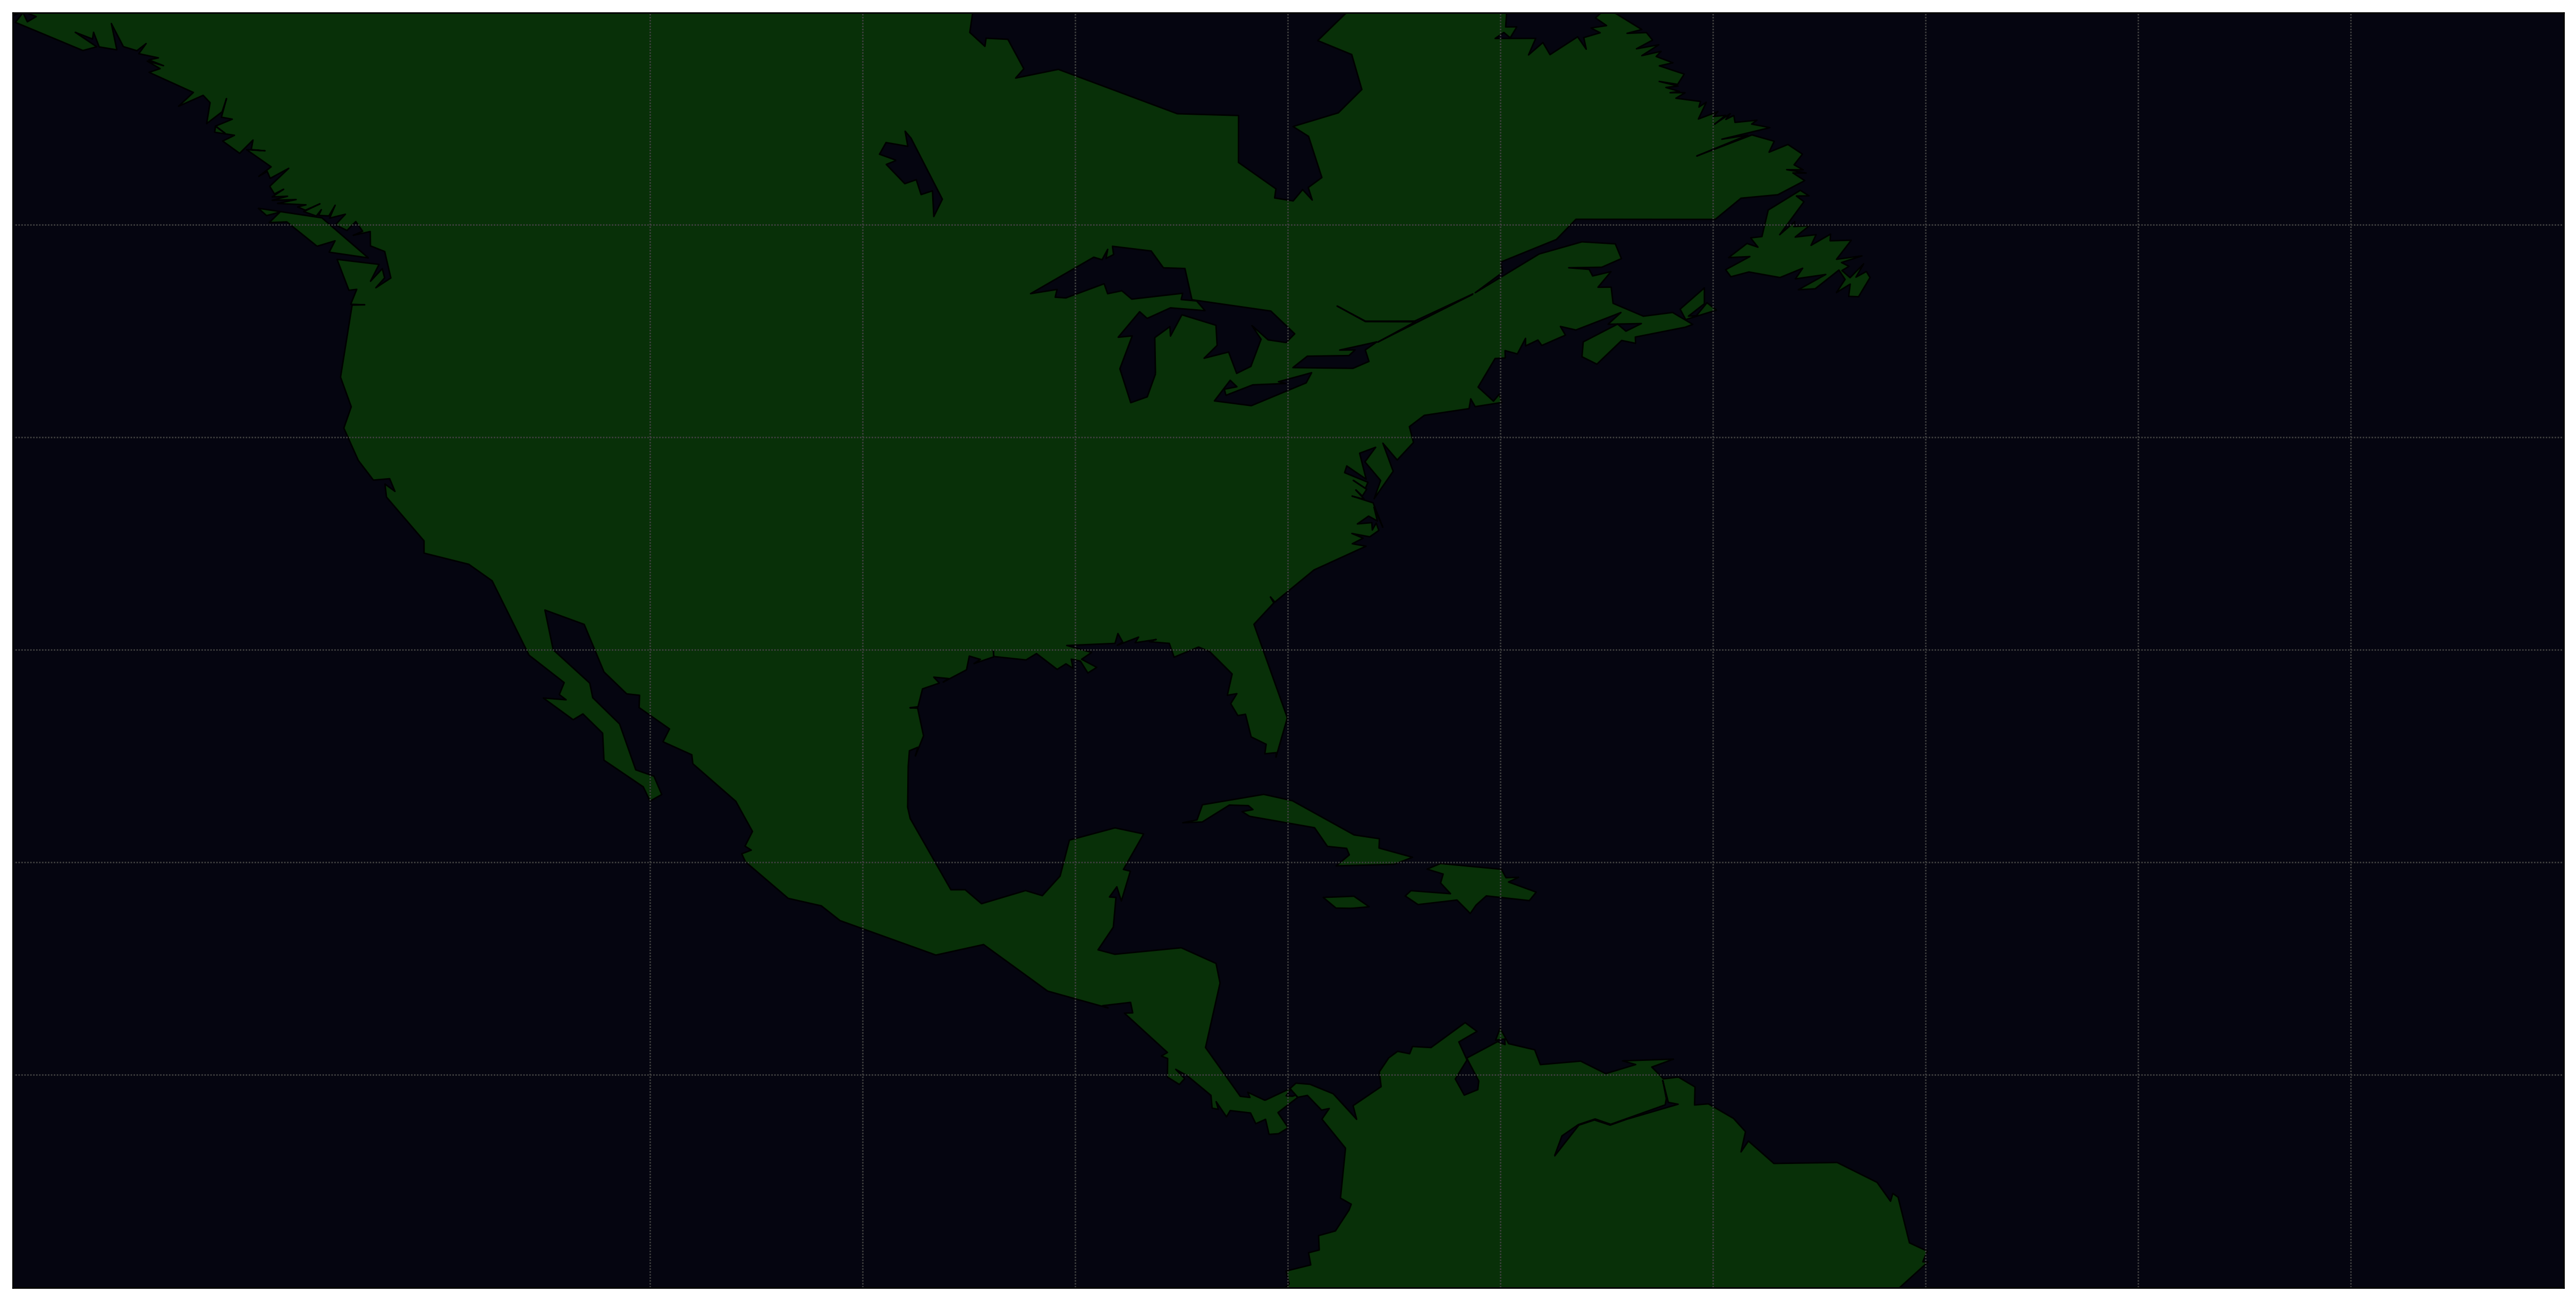

In [134]:

# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
# are the lat/lon values of the lower left and upper right corners
# of the map.
# lat_ts is the latitude of true scale.
# resolution = 'c' means use crude resolution coastlines.
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(24,12), dpi=200)
# ax.set_xlim(-120.0, -30.0)
# ax.set_ylim(10.0, 60.0)
m = Basemap(projection='cyl',llcrnrlat=0.0,urcrnrlat=60,\
            llcrnrlon=-140,urcrnrlon=-20.0,lat_ts=0,resolution='c', ax=ax)
m.drawcoastlines()
m.fillcontinents(color='#083008', lake_color='#050510')
# draw parallels and meridians.
m.drawparallels(np.arange(10.0, 60, 10.), color="#404040")
m.drawmeridians(np.arange(-110., -20., 10), color="#404040")
m.drawmapboundary(fill_color="#050510")
fig.subplots_adjust(0, 0, 1, 1)

fig.savefig("../imgs/fixed_map0.png", pad_inches=0, transparent=False)
# ax.set_title("Mercator Projection")
# plt.show()

In [100]:
Basemap?

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

from scipy import interpolate
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.misc import imread

In [84]:
def make_diagram(_year):
    '''
    do all of the stuff for the graphics of making a hurricane plot
    
    takes in the year dataframe in order to get the necessary data
    
    returns ax which is the figure axis that the current hurricane track will be added upon
    '''
        # establish the figure
    figure, axis = plt.subplots(figsize=(19.2,12.00), dpi=100)
    
    data = np.linspace(165.0, 0, 10000).reshape(100,100)
#     data = np.clip(randn(250, 250), -1, 1)

    histo_image = axis.imshow(data, interpolation='nearest', cmap="inferno")
    
    divider = make_axes_locatable(axis)
    
    cax = divider.append_axes("right", size="2%", pad=0.05)

    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    cbar = figure.colorbar(histo_image, ticks=[157, 130, 111, 96, 74, 39, 0], cax=cax)
    cbar.ax.set_yticklabels(['5^', '4^', '3^', '2^', '1^', 'T.S.^', 'T.D.^'])  # vertically oriented colorbar
    
    axis.imshow(map_image, extent=[-120, -30, 0, 50],zorder=0)
    axis.set_title("North American Hurricane Tracks " + str(_year), size=20)
    axis.set_xlabel("Longitude", size=16)
    axis.set_ylabel("Latitude", size=16)
    axis.set_facecolor("black")
    axis.set_xlim(-120.0, -30.0)
    axis.set_ylim(0, 50.0)
    
    return figure, axis

def make_historical_diagram():
    '''
    do all of the stuff for the graphics of making a hurricane plot
    
    takes in the year dataframe in order to get the necessary data
    
    returns ax which is the figure axis that the current hurricane track will be added upon
    '''
        # establish the figure
    figure, axis = plt.subplots(figsize=(19.2,12.00), dpi=100)
    
#     data = np.linspace(165.0, 0, 10000).reshape(100,100)
# #     data = np.clip(randn(250, 250), -1, 1)

#     histo_image = axis.imshow(data, interpolation='nearest', cmap="inferno")
    
#     divider = make_axes_locatable(axis)
    
#     cax = divider.append_axes("right", size="2%", pad=0.05)

#     # Add colorbar, make sure to specify tick locations to match desired ticklabels
#     cbar = figure.colorbar(histo_image, ticks=[157, 130, 111, 96, 74, 39, 0], cax=cax)
#     cbar.ax.set_yticklabels(['5^', '4^', '3^', '2^', '1^', 'T.S.^', 'T.D.^'])  # vertically oriented colorbar
    
#     axis.imshow(map_image, extent=[-120, -30, 0, 50],zorder=0)
#     axis.set_title("North American Hurricane Tracks " + str(_year), size=20)
#     axis.set_xlabel("Longitude", size=16)
#     axis.set_ylabel("Latitude", size=16)
#     axis.set_facecolor("black")
    axis.set_xlim(-120.0, -30.0)
    axis.set_ylim(0, 50.0)
    
    return figure, axis

def plot_historical_storm(ax, old_storm):
    '''
    returns axis that has had a historical storm scatter plot applied
    
    in long run make the rest of the scatter plot transparent so it can be additively added to historical stuff
    '''
    # get data for the plot
    old_length, old_lat, old_long, old_width, old_colors = transform_storm(old_storm, historical=True)
    
    
    # actually make the plot
    ax.scatter(old_long, old_lat, s=old_width, c=old_colors)

    
    
def transform_storm(storm, historical=False):
    ##################################
    # get np columns for key data ####
    ##################################
    _lat = storm.Latitude.apply(lambda x: float(x))
    _long = storm.Longitude.apply(lambda x: float(x))
    _width = (storm.loc[:, "saffir_simpson_cat"] + 2)**1.3 * 100
    _colors = storm.loc[:,"Wind(WMO)"].apply(lambda x: x / 165.0)
    
    x = np.arange(len(_lat))

    # Interpolate the data using a cubic spline to "new_length" samples
    # going from daily intervals to (interpolated) hourly
    if historical is False:
        new_length = 24 * len(_lat)
    else:
        new_length = 24 * len(_lat)

    # figure out length of new arrays
    new_x = np.linspace(x.min(), x.max(), new_length)

    # actually do the interpolation
    new_lat = interpolate.interp1d(x, _lat, kind='cubic')(new_x)
    new_long = interpolate.interp1d(x, _long, kind='cubic')(new_x)
    new_width = interpolate.interp1d(x, _width, kind='cubic')(new_x)
    new_colors = interpolate.interp1d(x, _colors, kind='cubic')(new_x)

    if historical is False:
        # convert colors from float to rgba using colormap
        new_colors = cm.inferno(new_colors)
    else:
        # must be doing a historical run, use a different color schema
        new_colors = cm.Greys(new_colors)
        
        # make white the 'hottest' and black the coolest
        new_colors = 1.0 - new_colors
        
        a_line = np.linspace(0.01, 0.01, new_length).reshape(1, new_length)
            
        # fix new_color alpha's with a_line alphas
#         new_colors[:,3] = a_line
        
        # try making the plot transparency 1.0 for historical
        new_colors[:,3] = 1.0

    return new_length, new_lat, new_long, new_width, new_colors

In [86]:
map_image = imread("../data/north_america_edited.png")

# make a list for the years
years = []

# step through the Seasons (years) and make a new dataframe for each one
for year in data_na.loc[:, "Season"].unique():
    temp = data_na[data_na.loc[:, "Season"] == year]
    years.append(temp)
    
# get rid of a nan DataFrame
years.pop(0)

#loop through years in future gif
start = 164 - (2016 - 2004)
end = 164 - (2016 - 2005)

print start, end

print "total years", len(years)

#how many historical years
trailing_years = 0

# max window size in years
yr_window = 3

for idz, year in enumerate(years[start:end]):
    
    # make a temp list to hold the storm dataframes from a single year
    storms = []
    
    # figure out what the year is
    _year = year.loc[:, "Season"].unique()[0]
    
    # start a new frame count for each year
    frame_count = 0

#         this_year = str(year.loc[:, "Season"].unique()[0])
#         print "year", this_year

    # step through the year and make a dataframe for each storm
    for storm in year.loc[:,"Serial_Num"].unique():
        storms.append(year[year.loc[:, "Serial_Num"] == storm])

    # now have a list of storm dataframes



    # step through all of the storms and add their tracks to the map
    for idy, storm in enumerate(storms):
        # old place to make diagram 

        # if the track has a very small number of data points then skip it
        if len(storm) < 10:
            pass
        else:            
            new_length, new_lat, new_long, new_width, new_colors = transform_storm(storm)
            
            # set trail duration, maybe 3 days which 24 ticks per day is 72
            track_length = 120
            
            # figure out number of frames for the track
            frames = new_length // track_length
            
            # figure out the number of leftover extra frames to use all steps
            left_over_frames = new_length % track_length
            
            # frame calculated stuff
            t_long = new_long[:left_over_frames]
            t_lat = new_lat[:left_over_frames]
            t_width = new_width[:left_over_frames]
            t_colors = new_colors[:left_over_frames]
            
            if left_over_frames != 0:         
                a_line = np.linspace(0.1, 0, left_over_frames)[::-1].reshape(1, left_over_frames)

                # fix t_color alpha's with a_line alphas
                t_colors[:,3] = a_line
            
#             print "a_line.shape", a_line.shape
#             print "t_color.shape", t_color.shape
            
            fig, ax = make_diagram(year)
        
            if idy > 0:
                for old_storm in storms[0:idy]:
                    old_length, old_lat, old_long, old_width, old_colors = transform_storm(old_storm, historical=True)
                    ax.scatter(old_long, old_lat, s=old_width, c=old_colors)
            
            ax.scatter(t_long, t_lat, s=t_width, c=t_colors)
            
            # for loop for each frame
            for frame in range(frames):      
                # print the year_storm_frame for practice for the file name saving
                _filename = "{:0>4}{:0>6}.png".format(_year, frame_count)
                _path = "../imgs/" + _filename
                
                # time window start:
                _ts = track_length * frame
                
                # time window end:
                _te = track_length * (frame + 1)
                
                a_line = np.linspace(1.0, 0, _te).reshape(1, _te)
            
                # frame calculated stuff
                t_long = new_long[: _te][::-1]
                t_lat = new_lat[: _te][::-1]
                t_width = new_width[: _te][::-1]
                t_colors = new_colors[: _te][::-1]

                # fix t_color alpha's with a_line alphas
                t_colors[:,3] = a_line

                fig, ax = make_diagram(year)
                
                if idy > 0:
                    for old_storm in storms[0:idy]:
                        old_length, old_lat, old_long, old_width, old_colors = transform_storm(old_storm, historical=True)
                        ax.scatter(old_long, old_lat, s=old_width, c=old_colors)

                ax.scatter(t_long, t_lat, s=t_width, c=t_colors)
                
#                 print "Saving {:>15}".format(_filename)
#                 fig.savefig(_path)
#                 plt.close("all")
                frame_count += 1
                

152 153
total years 164


KeyError: 'the label [saffir_simpson_cat] is not in the [columns]'

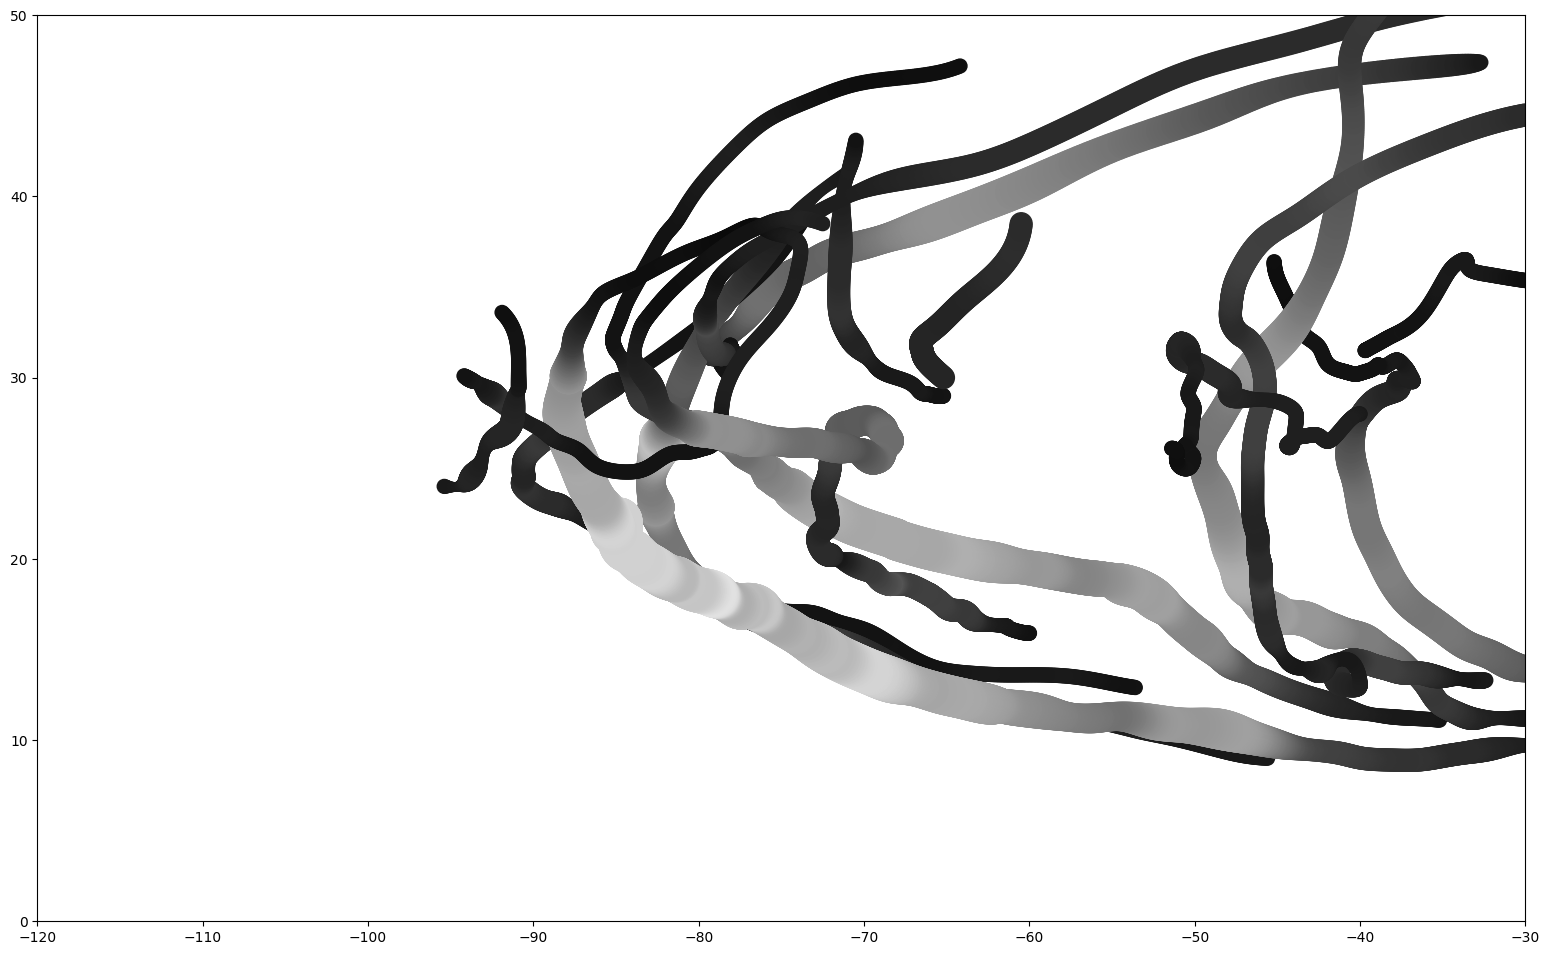

In [82]:
map_image = imread("../data/north_america_edited.png")

# make a list for the years
years = []

# step through the Seasons (years) and make a new dataframe for each one
for year in data_na.loc[:, "Season"].unique():
    temp = data_na[data_na.loc[:, "Season"] == year]
    years.append(temp)
    
# get rid of a nan DataFrame
years.pop(0)

#loop through years in future gif
start = 164 - (2016 - 2004)
end = 164 - (2016 - 2005)

year = years[start]

# make a temp list to hold the storm dataframes from a single year
storms = []

# figure out what the year is
_year = year.loc[:, "Season"].unique()[0]

# start a new frame count for each year
frame_count = 0

# step through the year and make a dataframe for each storm
for storm in year.loc[:,"Serial_Num"].unique():
    storms.append(year[year.loc[:, "Serial_Num"] == storm])
    
fig, ax = make_historical_diagram()

for storm in storms:
    plot_historical_storm(ax, storm)